In [1]:
!pip install -r requirements.txt

     |████████████████████████████████| 9.8 MB 6.5 MB/s eta 0:00:01
     |████████████████████████████████| 82 kB 13.4 MB/s eta 0:00:01
     |████████████████████████████████| 454 kB 12.2 MB/s eta 0:00:01
     |████████████████████████████████| 198 kB 12.7 MB/s eta 0:00:01
     |████████████████████████████████| 95 kB 14.9 MB/s eta 0:00:01
     |████████████████████████████████| 100 kB 14.0 MB/s ta 0:00:01
     |████████████████████████████████| 303 kB 12.4 MB/s eta 0:00:01


     |████████████████████████████████| 1.4 MB 13.3 MB/s eta 0:00:01
     |████████████████████████████████| 98 kB 14.0 MB/s eta 0:00:01
     |████████████████████████████████| 9.5 MB 13.0 MB/s eta 0:00:01
     |████████████████████████████████| 126 kB 12.8 MB/s eta 0:00:01
     |████████████████████████████████| 9.2 MB 9.4 MB/s eta 0:00:01
     |████████████████████████████████| 91 kB 14.1 MB/s eta 0:00:01
     |████████████████████████████████| 510 kB 12.3 MB/s eta 0:00:01
     |████████████████████████████████| 723 kB 12.6 MB/s eta 0:00:01
     |████████████████████████████████| 883 kB 12.4 MB/s eta 0:00:01
     |████████████████████████████████| 25.9 MB 12.2 MB/s eta 0:00:01     |███████████████████▊            | 16.0 MB 12.2 MB/s eta 0:00:01     |████████████████████████████▏   | 22.8 MB 12.2 MB/s eta 0:00:01
     |████████████████████████████████| 285 kB 13.0 MB/s eta 0:00:01
     |████████████████████████████████| 1.2 MB 13.1 MB/s eta 0:00:01
     |██████████████████████████████

     |████████████████████████████████| 1.1 MB 13.1 MB/s eta 0:00:01
     |████████████████████████████████| 3.2 MB 12.9 MB/s eta 0:00:01
     |████████████████████████████████| 804.1 MB 14.4 MB/s eta 0:00:01     |██████▌                         | 163.4 MB 14.1 MB/s eta 0:00:46     |███████████                     | 274.6 MB 12.4 MB/s eta 0:00:43     |███████████                     | 277.3 MB 12.4 MB/s eta 0:00:43     |█████████████████▎              | 434.3 MB 13.7 MB/s eta 0:00:28     |█████████████████▊              | 446.5 MB 11.9 MB/s eta 0:00:31     |██████████████████▍             | 462.2 MB 13.7 MB/s eta 0:00:26     |███████████████████▉            | 498.3 MB 13.3 MB/s eta 0:00:24     |██████████████████████          | 551.4 MB 13.4 MB/s eta 0:00:19     |██████████████████████▏         | 558.2 MB 13.4 MB/s eta 0:00:19     |███████████████████████▊        | 596.4 MB 13.9 MB/s eta 0:00:15     |██████████████████████████▊     | 672.1 MB 14.0 MB/s eta 0:00:10     |████████████████

In [5]:
import tensorflow as tf
print(tf.__version__)

from os import listdir
from transformers import ( 
    T5Tokenizer, 
    TFT5ForConditionalGeneration
)
import numpy as np
import time

import pickle

# import python files
import sys
sys.path.append("../..")

from python_files.language_tokens import LanguageTokens
from python_files.model_loader import ModelLoader
from python_files.tf_record_loader import TFRecordLoader


import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

2.4.1


In [6]:
model_size = "t5-base"

MAX_ARTICLE_LEN = 512

MAX_HIGHLIGHT_LEN = 150

BATCH_SIZE = 8

root_folder = "../.."

result_folder = root_folder + "/results/"

In [7]:
tokenizer = T5Tokenizer.from_pretrained(model_size)
language_tokens = LanguageTokens(tokenizer, "tf")
prefix_size = language_tokens.prefix_size
language_token_order = ["de_de", "en_de", "de_en", "en_en"]

In [8]:
tf_record_loader = TFRecordLoader(root_folder, language_tokens, prefix_size, MAX_ARTICLE_LEN, MAX_HIGHLIGHT_LEN, BATCH_SIZE)

sued_test_dataset = tf_record_loader.get_tfrecord_dataset("/data/sueddeutsche_test/")
sued_test_dataset.prefetch(1024)

<PrefetchDataset shapes: ((None, 512), (None, 512), (None, 150), (None, 150), (None, 512), (None, 512), (None, 150), (None, 150), (None, 512), (None, 512), (None, 150), (None, 150), (None, 512), (None, 512), (None, 150), (None, 150)), types: (tf.int32, tf.int32, tf.int32, tf.int32, tf.int32, tf.int32, tf.int32, tf.int32, tf.int32, tf.int32, tf.int32, tf.int32, tf.int32, tf.int32, tf.int32, tf.int32)>

In [9]:
def get_mask_weights(x):
    new_arr = []
    x_numpy = x.numpy()
    for x_i in x_numpy:
        # remove eos token 
        x_i[np.where(x_i == 1)] = 0.
        # remove pad token
        x_i[np.where(x_i == 0)] = 0.
        x_i[np.where(x_i > 0)] = 1.
        x_i = x_i.reshape(1,-1)
        new_arr.append(x_i.T@x_i)
        
    return tf.convert_to_tensor(new_arr, dtype=tf.float32)

In [10]:
def get_model_attention(model, input_ids, decoder_ids):
    mask = get_mask_weights(input_ids)
    outputs = model(input_ids, decoder_input_ids=decoder_ids, output_attentions=True)
    
    encoder_attention = outputs.encoder_attentions
    last_attention = tf.stack(encoder_attention, axis=0)
    
    # mean of attention heads 
    mean_last_att = tf.math.reduce_mean(last_attention, axis=[2])
    masked_mean = []
    for i in range(mean_last_att.shape[0]):
        masked_mean.append(mean_last_att[i] * mask) 
    
    masked_mean = tf.stack(masked_mean, axis=0)
        
    # mean batch
    masked_mean = tf.math.reduce_mean(masked_mean, axis=[1])

    masked_mean = masked_mean.numpy()
    return masked_mean

In [11]:
def normalize(x, cut_outliers=True):
    # cut of outliers
    if cut_outliers:
        variance = np.var(x)
        mean = np.mean(x)
        x[x>(variance + mean)] = mean + variance
        x[x<(mean - variance)] = mean - variance
    # normalize
    x_res = x/np.linalg.norm(x)
    return x_res

In [12]:
def get_single_example(text):
    input_ids = tokenizer([text], return_tensors="tf", max_length=512, truncation=True, padding='max_length').input_ids  
    decoder_ids = decoder_ids = tokenizer([""], return_tensors="tf", max_length=150, truncation=True, padding='max_length').input_ids
    x = get_model_attention(model, input_ids, decoder_ids)
    
    heat_map = []

    for x_i in x:
        x_flat = np.sum(x_i, axis=0)
        x_filled = normalize(x_flat)
#         x_filled = x_flat
        
        x_filled = x_filled.reshape(-1, 16)
        heat_map.append(x_filled)

    heat_map = np.array(heat_map)
    heat_map = np.mean(heat_map, axis=0)
    return heat_map, input_ids

def get_threshold(heat_map_weights, percentage=0.15):
    heat_map_weights_temp = np.array(heat_map_weights, copy=True)
    heat_map_weights_temp = np.trim_zeros(heat_map_weights_temp, 'b')
    threshold_size = int(heat_map_weights_temp.shape[0]*percentage)
    heat_map_weights_temp.sort()
    threshold = heat_map_weights_temp[heat_map_weights_temp.shape[0] - threshold_size]  
    return threshold
    


def get_most_attended_word(heatmap, input_ids):
    all_max_tokens = []
    heat_map_weights = heat_map.reshape(-1)
    threshold = get_threshold(heat_map_weights)
    for i, item in enumerate(heat_map_weights):
        if item > threshold:
            all_max_tokens.append(i)


    token_ids = [input_ids[0,i].numpy() for i in all_max_tokens]
    highlight_tokens = tokenizer.decode(token_ids)
    
    result_str = ""
    for i, item in enumerate(input_ids[0]):
        str_item = tokenizer.decode(item)
        if i in all_max_tokens:
            str_item = "\\textcolor{red}{" + str_item + "}"
        if str_item not in ['</s>','<pad>']:
            if str_item == ".":
                result_str = result_str[:-1]
            elif str_item == "#":
                str_item = "\#"
            result_str += str_item + " "
    print(result_str)

In [13]:
def plot_four_heatmaps(x_0, x_1, x_2, x_3, title, use_same_scale=False):
    fig = plt.figure(constrained_layout=True, figsize=(20, 12))
#     cmap = "Blues"
#     cmap = sns.diverging_palette(145, 300, s=60, as_cmap=True)
 
    
    cmap = "Spectral"
    spec = plt.GridSpec(2, 2, figure=fig)
    f_ax0_0 = fig.add_subplot(spec[0, 0])
    f_ax0_1 = fig.add_subplot(spec[0, 1])
    f_ax1_0 = fig.add_subplot(spec[1, 0])
    f_ax1_1 = fig.add_subplot(spec[1, 1])
    
    if use_same_scale:
        min_x = np.min(np.concatenate([x_0, x_1, x_2, x_3]))
        max_x = np.max(np.concatenate([x_0, x_1, x_2, x_3]))
        ax_0_0 = sns.heatmap(x_0, ax=f_ax0_0, vmin=min_x, vmax=max_x, yticklabels=["{} - {}".format(i*16, (i+1)*16) for i in range(32)], cmap = cmap).set_title(title[0])
        ax_0_1 = sns.heatmap(x_1, ax=f_ax0_1, vmin=min_x, vmax=max_x, yticklabels=["{} - {}".format(i*16, (i+1)*16) for i in range(32)], cmap = cmap).set_title(title[1])
        ax_1_0 = sns.heatmap(x_2, ax=f_ax1_0, vmin=min_x, vmax=max_x, yticklabels=["{} - {}".format(i*16, (i+1)*16) for i in range(32)], cmap = cmap).set_title(title[2])
        ax_1_1 = sns.heatmap(x_3, ax=f_ax1_1, vmin=min_x, vmax=max_x, yticklabels=["{} - {}".format(i*16, (i+1)*16) for i in range(32)], cmap = cmap).set_title(title[3])
    else:
        ax_0_0 = sns.heatmap(x_0, ax=f_ax0_0, yticklabels=["{} - {}".format(i*16, (i+1)*16) for i in range(32)], cmap = cmap).set_title(title[0])
        ax_0_1 = sns.heatmap(x_1, ax=f_ax0_1, yticklabels=["{} - {}".format(i*16, (i+1)*16) for i in range(32)], cmap = cmap).set_title(title[1])
        ax_1_0 = sns.heatmap(x_2, ax=f_ax1_0, yticklabels=["{} - {}".format(i*16, (i+1)*16) for i in range(32)], cmap = cmap).set_title(title[2])
        ax_1_1 = sns.heatmap(x_3, ax=f_ax1_1, yticklabels=["{} - {}".format(i*16, (i+1)*16) for i in range(32)], cmap = cmap).set_title(title[3])
    
    plt.show()

### Load Sueddeutsche model

In [26]:
# sueddeutsche
model_loader = ModelLoader(model_size, root_folder+"/models", "t5_sueddeutsche") 
model = model_loader.load_epoch(9)

All model checkpoint layers were used when initializing TFT5ForConditionalGeneration.

All the layers of TFT5ForConditionalGeneration were initialized from the model checkpoint at t5-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


## Random Sueddeutsche example

In [27]:
input_text_en = " The coalition factions of the CDU / CSU and SPD have confirmed that they will abolish the solidarity surcharge for 90 percent of taxpayers as of 1 January 2021. This was agreed by the executive committee of the parliamentary group in Berlin. Employees are to be relieved by approximately ten billion euros per year. A joint paper by the two groups stresses that this is \"a first step.\" In addition, the better tax deductibility of research and development expenditure agreed by the Federal Government is to be introduced indefinitely. The government groups also want to ensure that the effect of the so-called \"Cold Progression\" on taxpayers is offset. There should be a rate adjustment on income tax. The stipulations are an indication that corresponding government projects should pass the Bundestag with a majority of the Union and the SPD without major problems. The leaders of the parliamentary groups met for the first time after the European elections, which were heavy losses for the Union and the SPD, and the resignation of SPD leader Andrea Nahles. On Thursday, both sides had already stressed the readiness for further cooperation in the grand coalition and stability."
input_text_de = " Die Koalitionsfraktionen von CDU/CSU und SPD haben bekräftigt, den Solidaritätszuschlag zum 1. Januar 2021 für 90 Prozent der Steuerzahler abschaffen. Darauf haben sich die geschäftsführenden Fraktionsvorstände in Berlin geeinigt. Die Beschäftigten sollen damit um etwa zehn Milliarden Euro pro Jahr entlastet werden. In einem gemeinsamen Papier der beiden Fraktionen wird betont, dass es sich um \"einen ersten Schritt\" handelt. Zudem soll die von der Bundesregierung vereinbarte bessere steuerliche Absetzbarkeit von Forschungs- und Entwicklungsausgaben unbefristet eingeführt werden. Die Regierungsfraktionen wollen zudem dafür sorgen, dass der Effekt der sogenannten \"Kalten Progression\" für Steuerzahler ausgeglichen wird. Dazu soll es eine Tarifanpassung bei der Einkommensteuer geben. Die Festlegungen sind ein Hinweis darauf, dass entsprechende Regierungsvorhaben den Bundestag mit der Mehrheit von Union und SPD ohne große Probleme passieren dürften. Die Fraktionsspitzen hatten sich das erste Mal nach den für Union und SPD verlustreichen Europawahlen und dem Rücktritt von SPD-Chefin Andrea Nahles getroffen. Bereits am Donnerstag hatten beide Seiten die Bereitschaft zu einer weiteren Zusammenarbeit in der großen Koalition und die Stabilität betont."

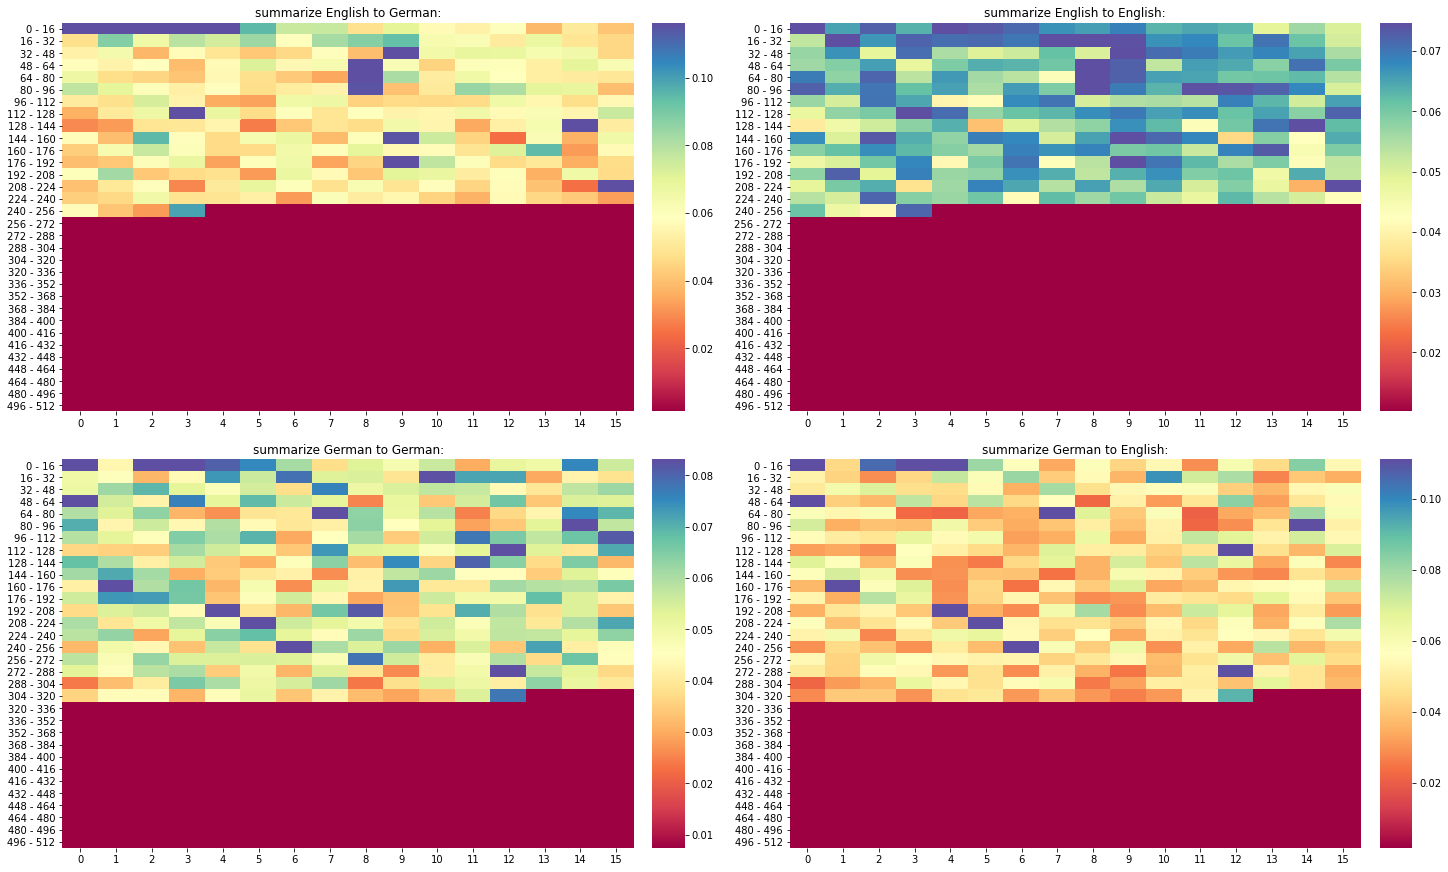

In [28]:
tokens_en = ["summarize English to German:", "summarize English to English:"]
tokens_de = ["summarize German to German:", "summarize German to English:"]

all_language_directions = []
for token in tokens_en:
    heat_map, input_ids = get_single_example(token + input_text_en)
    all_language_directions.append(heat_map)
    
for token in tokens_de:
    heat_map, input_ids = get_single_example(token + input_text_de)
    all_language_directions.append(heat_map)
    
plot_four_heatmaps(all_language_directions[0], all_language_directions[1], all_language_directions[2], all_language_directions[3], tokens_en + tokens_de)

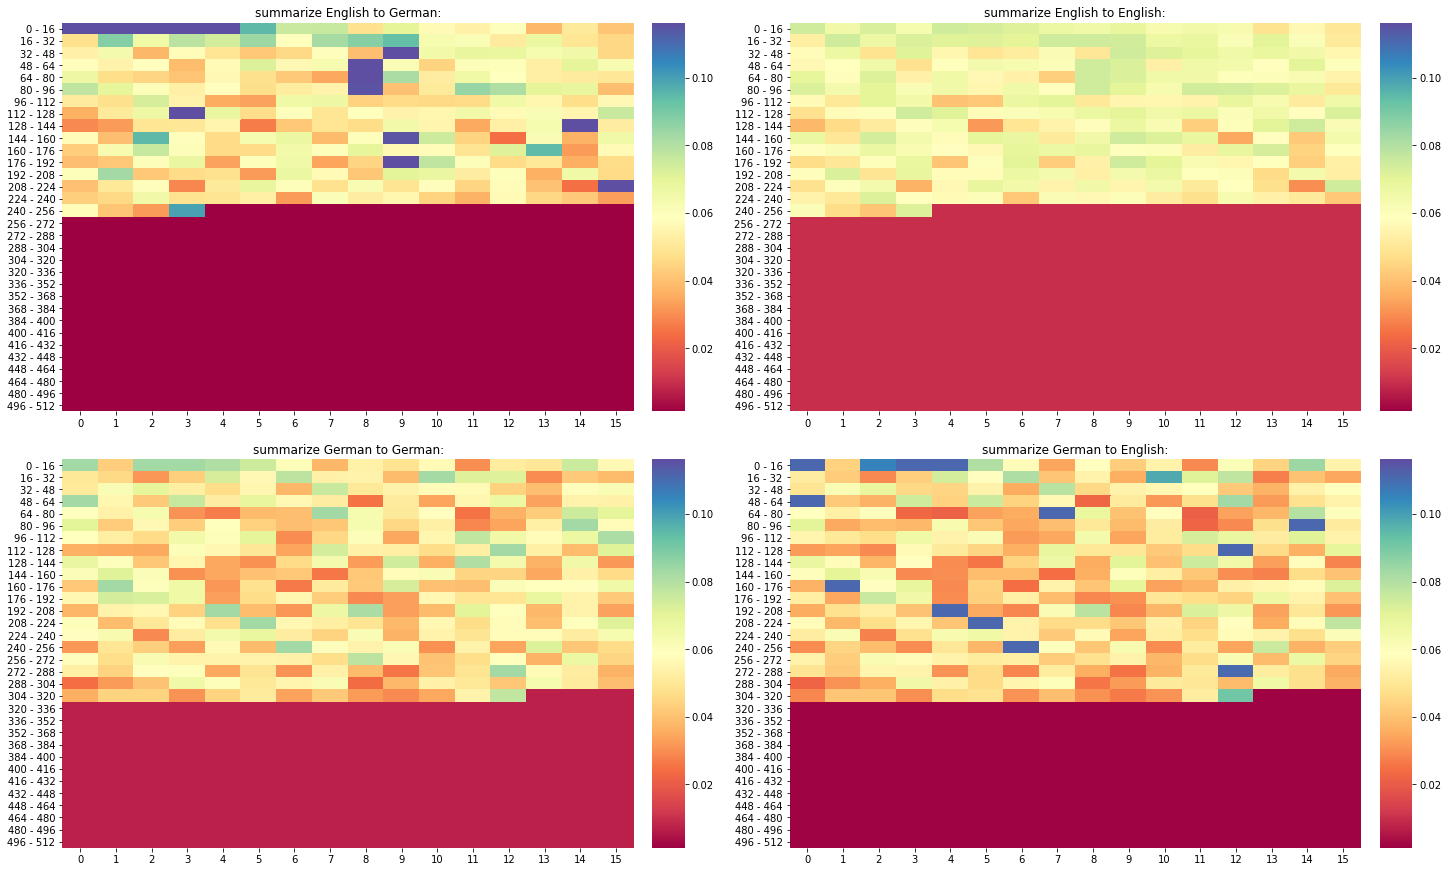

In [29]:
plot_four_heatmaps(all_language_directions[0], all_language_directions[1], all_language_directions[2], all_language_directions[3], tokens_en + tokens_de, True)

In [17]:
heat_map, input_ids = get_single_example(tokens_en[1] + input_text_en)
get_most_attended_word(heat_map, input_ids)

\textcolor{red}{summarize} English \textcolor{red}{to} English \textcolor{red}{:} \textcolor{red}{The} \textcolor{red}{coalition} faction s \textcolor{red}{of} the C DU  / C SU \textcolor{red}{and} SPD \textcolor{red}{have} \textcolor{red}{confirmed} \textcolor{red}{that} \textcolor{red}{they} \textcolor{red}{will} \textcolor{red}{abolish} \textcolor{red}{the} \textcolor{red}{solidarity} \textcolor{red}{sur} charge \textcolor{red}{for} 90 percent of taxpayer s \textcolor{red}{as} of 1 January 20 21 \textcolor{red}{.} \textcolor{red}{This} \textcolor{red}{was} agreed \textcolor{red}{by} the executive committee of the  parliamentary group in Berlin \textcolor{red}{.} \textcolor{red}{Employee} s are to be \textcolor{red}{relieve} d \textcolor{red}{by} approximately \textcolor{red}{} ten billion euros per year \textcolor{red}{.} \textcolor{red}{A} joint paper by the two groups \textcolor{red}{stresses} that \textcolor{red}{this} is " a first step \textcolor{red}{."} \textcolor{red}{In} add

## Cerry picked example Sueddeutsche

In [30]:
input_text_de = " Für 29,99 Euro nach Antalya, für 39,99 Euro nach Djerba oder Jerez de la Frontera - wer Condor fliegt, fliegt mit ein bisschen Glück gerade sehr günstig. Auf der Website bewirbt die Ferienfluggesellschaft die Niedrigtarife unter dem Label \"Kurzfliegen\" - also nicht so weit weg und mal kurz für ein paar Tage in die Sonne, es ist ja günstig. Neu ist das Konzept nicht, aber nun entfaltet sich eine politische Diskussion um die Preise, die für das Unternehmen gefährlich werden könnte. Bietet Condor, gerade mit einem Staatskredit von 380 Millionen Euro über Wasser gehalten, Flüge zum Dumpingtarif an? Und wie verträgt sich das mit dem Klimapakt? \"Kampfpreise und Marktgewinnungsstrategien mit Steuergeld zu machen, ist ein Unding\", sagt der stellvertretende Vorsitzende der FDP-Bundestagsfraktion Michael Theurer. \"Der Bundestag muss Zugang zu sämtlichen Unterlagen bekommen, damit sich die Abgeordneten ein Bild davon machen können, ob eine Zweckentfremdung des Kredits vorliegt\", so der Politiker. \"Eine Wettbewerbsverzerrung mit Staatsknete und eine Quersubventionierung von Billigtickets sind inakzeptabel.\" Die Bundesregierung und das Land Hessen hatten nach der Pleite des Reiseveranstalters Thomas Cook, zu dem Condor gehört, zugesagt, für einen KfW-Kredit zu bürgen. Das Geld braucht Condor für den kommenden Winter, in dem Ferien-Airlines traditionell Verluste machen, die sie, wenn es gut läuft, im Sommer überkompensieren. Durch die Pleite der Muttergesellschaft war das Cash-Polster für die aufkommensschwache Zeit weg. Condor bekam den Kredit und befindet sich in einem Schutzschirmverfahren, einer Variante der Insolvenz, bei der das Unternehmen nach drei Monaten ein Insolvenzverfahren in Eigenverwaltung durchlaufen kann. Auch die Condor-Konkurrenz murrt schon vernehmlich, dass sie es nun mit einer staatlich unterstützten Fluggesellschaft aufnehmen muss, die über Billigpreise Marktanteile gewinnen wolle. Bei Tuifly kostet der Flug nach Heraklion mindestens 93,74 Euro, bei Condor dagegen nur 39,99 Euro. Lufthansa-Ableger Eurowings bietet viele europäische Ziele für Preise ab 29,99 Euro an, Heraklion gibt es ab 49,99 Euro. Allerdings erhält Eurowings keine Staatshilfen, und normalerweise wird nur ein kleiner Teil der Kapazität im Einzelplatzverkauf zu diesen Einstiegspreisen angeboten. Bei Condor aber geht es auch um die Kontingente, die die Airline an Reiseveranstalter verkaufen will, nachdem ihr durch die Thomas-Cook-Pleite 20 Prozent der Kunden verloren gegangen sind. Die Veranstalter greifen derzeit gerne die Billigkontingente ab, so ein Insider, und decken sich damit für den Winter ein. \"Das ist nicht vergleichbar mit den Vorjahren\", sagt er. Condor-Vertriebschef Paul Schwaiger hofft, die hohe Nachfrage der anderen Veranstalter werde die Lücke schließen. Zu spüren bekommen dies nun Konkurrenten wie Eurowings, Tuifly oder Sun Express. Heikle Situation für die Bundesregierung \"Alle Airlines bieten derzeit attraktive Angebote für Flüge in der Nebensaison, um diese auszulasten, so auch Condor\", teilte Condor mit. Bei den Günstigtarifen handele es sich um eine lang geplante Preisaktion, die sich mit der Insolvenz der Thomas Cook überschnitten habe und nicht mehr gestoppt werden konnte. Sie sei am 3. Oktober ausgelaufen. Die günstigen Angebote für Einzelplätze waren aber auch danach noch verfügbar. Den Reiseveranstaltern werden dem Vernehmen nach ebenfalls weiterhin günstige Angebote unterbreitet. Ein Beobachter weist darauf hin, dass auch Air Berlin nach dem Insolvenzantrag im August 2017 versucht habe, der Konkurrenz Marktanteile abzunehmen. Für die Bundesregierung ist die Situation politisch heikel. Gerade erst hat sie im Klimapakt beschlossen, die Luftverkehrsabgabe zu erhöhen, um das Fliegen zu verteuern und zu verhindern, dass die Fluggesellschaften zu billige Tickets verkaufen, die die wahren (Umwelt-)Kosten der Reisen nicht widerspiegeln. Die Union hatte darüber hinaus ernsthaft erwogen, den Airlines Mindestpreise von rund 50 Euro vorzuschreiben. Ins Klimapaket der Bundesregierung wurde diese Forderung letztlich aber nicht übernommen. Hingegen soll die Steuer nach einem Referentenentwurf des Bundesfinanzministeriums erhöht werden - um 2,93 Euro für Strecken innerhalb Deutschlands und Europas (Distanzklasse 1) und um 16,45 Euro für Langstrecken (Distanzklasse 3). Bei einem Langstreckenflug sind damit künftig 58,63 Euro fällig, bei Kurzstrecken 10,43 Euro. Insgesamt soll die Steuer die Branche mit rund 500 Millionen Euro belasten."
input_text_en = " For 29.99 euros to Antalya, for 39.99 euros to Djerba or Jerez de la Frontera - if you fly Condor, you will fly very cheaply with a bit of luck. On the website, the holiday airline advertises the low fares under the label \"short flights\" - so not so far away and for a few days in the sun, its cheap. The concept is not new, but now a political discussion is unfolding about prices, which could be dangerous for the company. Does Condor, which has just been kept afloat by a state loan of EUR 380 million, offer flights at a dumping rate? And how is that compatible with the climate pact? \" To make fighting prices and market winning strategies with tax money, is an nonsense, \"says the deputy chairman of the FDP parliamentary group Michael Theurer.\" The Bundestag must get access to all documents, so that the members of parliament can get an idea of whether the loan has been misused, \"the politician said. Distortion of competition with government clay and cross-subsidisation of cheap tickets is unacceptable. \" Following the bankruptcy of the tour operator Thomas Cook, to which Condor belongs, the Federal Government and the Land of Hesse had agreed to guarantee a KfW loan. Condor needs the money for the coming winter, when holiday airlines traditionally make losses, which they over-compensate in the summer when things are going well. The bankruptcy of the parent company eliminated the cash cushion for the low-income period. Condor got the loan and is in a protective shield procedure, a variant of insolvency, in which the company can go through insolvency proceedings in self-administration after three months. Also the Condor competition grumbles already audibly that it must now take on a state-supported airline, which wants to gain market share by low prices. With Tuifly the flight to Heraklion costs at least 93.74 euros, with Condor on the other hand only 39.99 euros. Lufthansa offshoot Eurowings offers many European destinations for prices starting from 29.99 euros, Heraklion is available from 49.99 euros. However, Eurowings does not receive any state aid and normally only a small part of the capacity is offered in single seat sales at"

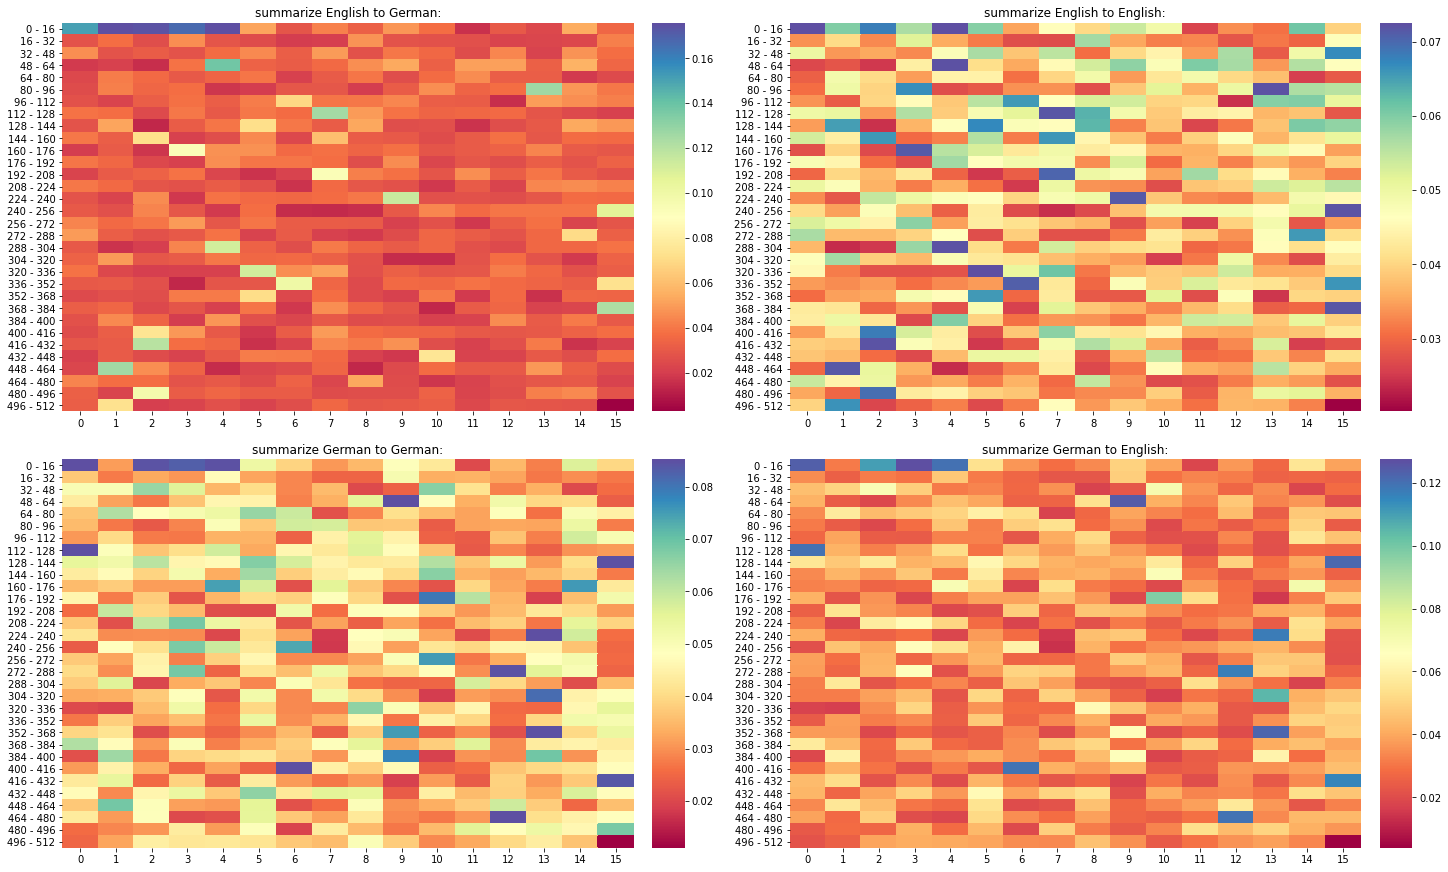

In [31]:
all_language_directions = []
for token in tokens_en:
    heat_map, input_ids = get_single_example(token + input_text_en)
    all_language_directions.append(heat_map)
    
for token in tokens_de:
    heat_map, input_ids = get_single_example(token + input_text_de)
    all_language_directions.append(heat_map)
    
plot_four_heatmaps(all_language_directions[0], all_language_directions[1], all_language_directions[2], all_language_directions[3], tokens_en + tokens_de)

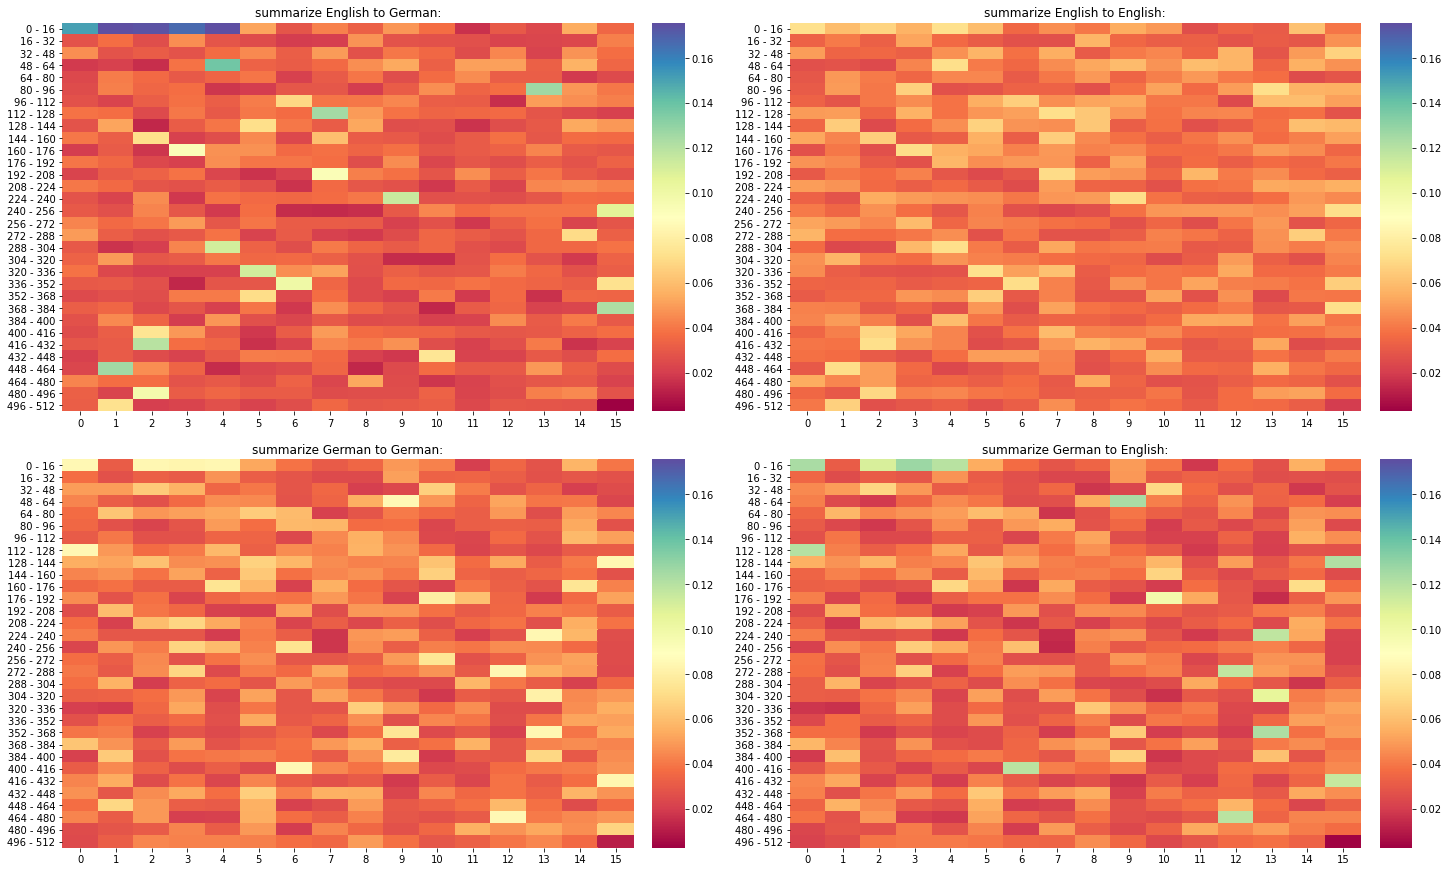

In [33]:
plot_four_heatmaps(all_language_directions[0], all_language_directions[1], all_language_directions[2], all_language_directions[3], tokens_en + tokens_de, True)

In [34]:
heat_map, input_ids = get_single_example(tokens_en[1] + input_text_en)
get_most_attended_word(heat_map, input_ids)

\textcolor{red}{summarize} \textcolor{red}{English} \textcolor{red}{to} \textcolor{red}{English} \textcolor{red}{:} \textcolor{red}{For} 2 9.99 euros \textcolor{red}{to} Ant a ly a \textcolor{red}{,} for 3 9.99 euros to D jer b a \textcolor{red}{or} Je rez de la Front era  -  if you fly \textcolor{red}{Condo} r \textcolor{red}{,} you will fly very \textcolor{red}{cheap} ly with \textcolor{red}{} a bit of luck \textcolor{red}{.} On the website , \textcolor{red}{the} holiday \textcolor{red}{airline} \textcolor{red}{advertise} s \textcolor{red}{the} low  fares under the label " s hort flights "  - so not so far away and for \textcolor{red}{} a few days in the sun , its cheap \textcolor{red}{.} \textcolor{red}{The} \textcolor{red}{concept} is not new , but \textcolor{red}{now} \textcolor{red}{} a political \textcolor{red}{discussion} is unfold ing \textcolor{red}{about} \textcolor{red}{prices} , which could be \textcolor{red}{dangerous} for the company \textcolor{red}{.} \textcolor{red}{Do

## Random CNN Daily Mail Example

In [35]:
model_loader = ModelLoader(model_size, root_folder+"/models", "t5_cnn_daily_mail") 
model = model_loader.load_epoch(9)

All model checkpoint layers were used when initializing TFT5ForConditionalGeneration.

All the layers of TFT5ForConditionalGeneration were initialized from the model checkpoint at t5-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


In [36]:
input_text_en = "The shooting of African-American, father-of-\
four Walter Scott by a white cop has provoked a torrent of anger and grief from celebrities on\
social media. Mr Scott, 50, was gunned down by Officer Michael Slager on Saturday morning\
in Charleston, South Carolina, when he ran from the cop. Pop star and member of Destinys\
Child, Michelle Williams, wrote: ’Once again... #WalterScott’ and added a broken heart. Singer\
Janelle Monáe said: ’This brought tears to my eyes. #WalterScott reminds me of my uncle,\
family. Can only imagine the pain his fam feels.’ Rapper Big Boi simply tweeted an image\
of a black square with the words: ’#WalterScott’. Scroll down for video . Destiny’s Child\
member Michelle Williams tweeted about her grief over the shooting of father-of-four Walter\
Scott in South Carolina on Saturday . A number of celebrities joined a torrent of outrage from\
Twitter users over the shooting on Walter Scott. Rapper Big Boi simply published a black\
square with the words: #WalterScott . Singer Janelle Monae also added her condolences on\
Twitter following the shooting of the father-of-four . Musician Questlove shared his anger\
with followers through his posts after it emerged that Scott had been running from the cop\
with his back turned when he was shot dead . Mr Scott, 50, was gunned down by Officer\
Michael Slager on Saturday morning in Charleston, South Carolina and pronounced dead at\
the scene . Musician Questlove wrote: ’I believe in waiting to hear everything before casting\
opinion. But allow me the preemptive...uh...shot of \"I feared for my life\" my ass.’ He went on:\
’Can you imagine the amount of murders that went down before the age and development of\
cell phone videos? this didn’t start this year.’ The star added: ’i was numb, now I’m angry.\
i rarely cuss here out of respect. but I’m angry as f***. good night.’ Actor Isaiah Washington\
tweeted: ’Okay, watching the #WalterScott video was horrible, but I think the brave person\
who"

input_text_de = "Die Erschießung des Afroamerikaners und vierfachen Vaters Walter Scott durch\
einen weißen Polizisten hat bei Prominenten in den sozialen Medien eine Flut von Wut und Trauer\
ausgelöst. Der 50-jährige Scott war am Samstagmorgen in Charleston, South Carolina, von dem Polizisten\
Michael Slager niedergeschossen worden, als er vor ihm weglief. Popstar und Mitglied von Destiny 's\
Child, Michelle Williams, schrieb: \"Wieder einmal... # WalterScott \"und fügte ein gebrochenes\
Herz hinzu. Sängerin Janelle Monáe sagte: \"Das hat mir Tränen in die Augen getrieben. # WalterScott\
erinnert mich an meinen Onkel, meine Familie. Kann sich nur vorstellen, welchen Schmerz seine Familie\
empfindet \". Rapper Big Boi twitterte einfach ein Bild eines schwarzen Quadrats mit den Worten \"# WalterScott\"\
. Scrollen Sie nach unten für ein Video. Destiny 's Child Mitglied Michelle Williams twitterte ihre Trauer \
über die Erschießung des vierfachen Vaters Walter Scott in South Carolina am Samstag. Eine Reihe von Prominenten\
schloss sich einem Sturm der Entrüstung von Twitter-Usern über die Schießerei auf Walter Scott an. Rapper\
Big Boi veröffentlichte einfach ein schwarzes Quadrat mit den Worten: # WalterScott. Sängerin Janelle Monae \
kondolierte ebenfalls auf Twitter nach der Erschießung des vierfachen Familienvaters. Musiker Questlove teilte\
seinen Ärger mit Followern durch seine Posts, nachdem bekannt wurde, dass Scott dem Polizisten den Rücken\
zugedreht hatte, als er erschossen wurde. Herr Scott, 50, wurde am Samstagmorgen in Charleston, South Carolina,\
von Offizier Michael Slager niedergeschossen und am Tatort für tot erklärt. Musiker Questlove schrieb: \
\"Ich glaube daran, alles abzuwarten, bevor ich meine Meinung äußere. Aber erlauben Sie mir den präventiven...\
äh... Schuss von \"Ich fürchtete um mein Leben\" meinen Arsch \". Er fuhr fort: \"Können Sie sich vorstellen,\
wie viele Morde es vor dem Zeitalter und der Entwicklung von Handyvideos gegeben hat? Das hat in diesem Jahr\
nicht angefangen \". Der Star fügte hinzu: \"Ich war taub, jetzt bin ich wütend. Ich rede hier selten aus Respekt.\
Aber ich bin wütend wie f * * *. Gute Nacht \". Schauspieler Isaiah Washington twitterte: \"Okay, das\
# WalterScott-Video anzusehen war schrecklich, aber ich denke, die tapfere Person, die den Mord festhielt, \
ist ein Held und ein Glücksfall # Truthdom\". Der ehemalige \"Grey 's Anatomy\" -Star änderte auch sein\
Profilbild zu dem einer Statue, die der Künstler Phillip Hyman zu Ehren von Scotts Tod an einem Straßenrand \
in South Carolina geschaffen hatte. Offizier Slager behauptete zunächst, er fürchte um sein Leben und Scott\
habe ihm einen Taser entrissen. Jedoch tauchte am Dienstag ein Video auf, auf dem zu sehen ist, wie Slager \
achtmal auf das Opfer feuert, als es 15-20 Fuß entfernt mit dem Rücken gewendet war. Schauspieler Isaiah \
Washington twitterte: \"Okay, das # WalterScott-Video anzusehen war schrecklich, aber ich denke, die \
tapfere Person, die den Mord festhielt, ist ein Held und ein Geschenk des Himmels # Truthdom\". \
Eine Skulptur wurde nach der Erschießung des unbewaffneten, schwarzen und vierfachen Vaters Walter Scott am \
Straßenrand in Charleston, South Carolina, als Denkmal aufgestellt. Komiker Orlando Jones, der aus demselben \
Bundesstaat stammt wie Walter Scott, teilte seine Wut auf Twitter. Slager wurde am Mittwoch des Mordes angeklagt\
und könnte die Todesstrafe drohen. Der Senator von South Carolina, Tim Scott, äußerte sich ebenfalls zu dem Mord \
und bezeichnete Scotts Tod als \"unnötig und vermeidbar\". Er fügte hinzu: \"Mein Herz schmerzt für die Familie\
und unsere Gemeinschaft in North Charleston\". Drehbuchautor und Regisseur Joss Whedon twitterte: \"An \
diesem Punkt erscheint der Mord an Slager wie eine Botschaft, ein Mafia-Ding, wie es dazu gedacht ist, \
Menschen auszuschalten oder loszuwerden. ES MUSS ENDE \". TV-Moderator Geraldo Rivera fügte hinzu: \"Kein\
Spin-Video zeigt eindeutig den weißen N. Charleston Cop schießt flüchtenden schwarzen Mann achtmal in den\
Rücken... Wenn dieser freigesprochen wird, werde ich mich dem Protest anschließen \". Herr Scott"

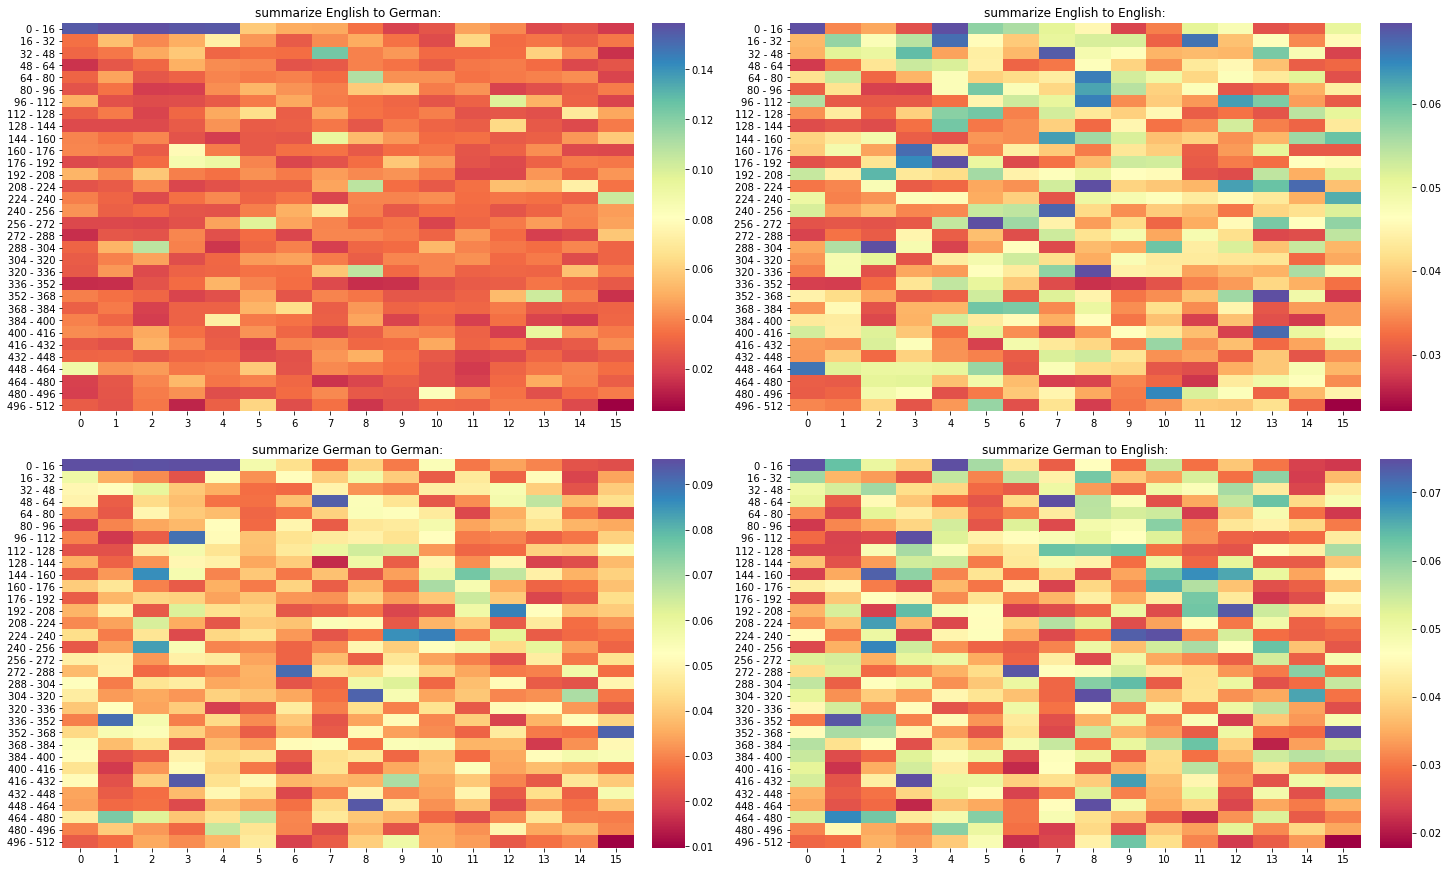

In [37]:
all_language_directions = []
for token in tokens_en:
    heat_map, input_ids = get_single_example(token + input_text_en)
    all_language_directions.append(heat_map)
    
for token in tokens_de:
    heat_map, input_ids = get_single_example(token + input_text_de)
    all_language_directions.append(heat_map)
    
plot_four_heatmaps(all_language_directions[0], all_language_directions[1], all_language_directions[2], all_language_directions[3], tokens_en + tokens_de)

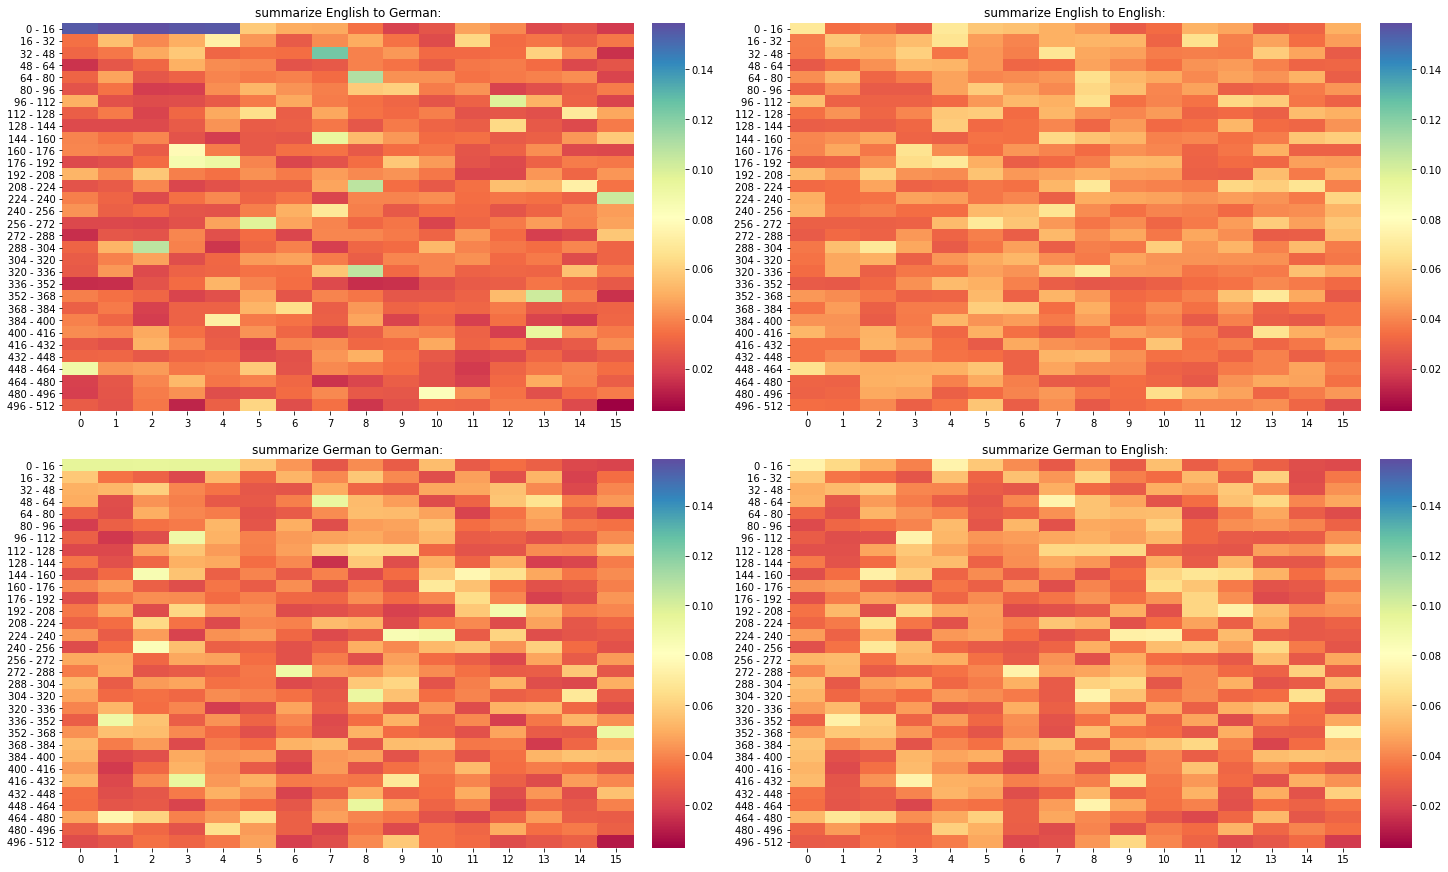

In [38]:
plot_four_heatmaps(all_language_directions[0], all_language_directions[1], all_language_directions[2], all_language_directions[3], tokens_en + tokens_de, True)

In [39]:
heat_map, input_ids = get_single_example(tokens_en[1] + input_text_en)
get_most_attended_word(heat_map, input_ids)

\textcolor{red}{summarize} English to English \textcolor{red}{:} \textcolor{red}{The} \textcolor{red}{shooting} of African - American , father - of - four \textcolor{red}{Walter} Scott \textcolor{red}{by} \textcolor{red}{} a white cop has provoke d \textcolor{red}{} a torrent of anger and grief from \textcolor{red}{celebrities} on social media \textcolor{red}{.} Mr Scott , 50 , \textcolor{red}{was} gun n e d down \textcolor{red}{by} Officer Michael S lager on Saturday morning in Charleston , South Carolina , \textcolor{red}{when}  he ran from the cop \textcolor{red}{.} Pop star and member of Destin y s Ch il d , \textcolor{red}{Michelle} Williams , \textcolor{red}{wrote} \textcolor{red}{:}  ’ O nce again ... \textcolor{red}{#} W alter S cott ’ \textcolor{red}{and} added \textcolor{red}{} a broken heart \textcolor{red}{.} \textcolor{red}{Singer} J an elle Mon á e \textcolor{red}{said} \textcolor{red}{:}  ’ This brought tears to my eyes \textcolor{red}{.} \# W alter S cott \textcolor{red